# 03 - Interactive Viz

## Deadline

Wednesday November 8th, 2017 at 11:59PM

## Important Notes

- Make sure you push on GitHub your Notebook with all the cells already evaluated
- Note that maps do not render in a standard Github environment : you should export them to HTML and link them in your notebook.
- Remember that `.csv` is not the only data format. Though they might require additional processing, some formats provide better encoding support.
- Don't forget to add a textual description of your thought process, the assumptions you made, and the solution you plan to implement!
- Please write all your comments in English, and use meaningful variable names in your code

## Background

In this homework we will be exploring interactive visualization, which is a key ingredient of many successful data visualizations (especially when it comes to infographics).

Unemployment rates are major economic metrics and a matter of concern for governments around the world. Though its definition may seem straightforward at first glance (usually defined as the number of unemployed people divided by the active population), it can be tricky to define consistently. For example, one must define what exactly unemployed means : looking for a job ? Having declared their unemployment ? Currently without a job ? Should students or recent graduates be included ? We could also wonder what the active population is : everyone in an age category (e.g. `16-64`) ? Anyone interested by finding a job ? Though these questions may seem subtle, they can have a large impact on the interpretation of the results : `3%` unemployment doesn't mean much if we don't know who is included in this percentage. 

In this homework you will be dealing with two different datasets from the statistics offices of the European commission ([eurostat](http://ec.europa.eu/eurostat/data/database)) and the Swiss Confederation ([amstat](https://www.amstat.ch)). They provide a variety of datasets with plenty of information on many different statistics and demographics at their respective scales. Unfortunately, as is often the case is data analysis, these websites are not always straightforward to navigate. They may include a lot of obscure categories, not always be translated into your native language, have strange link structures, â€¦ Navigating this complexity is part of a data scientists' job : you will have to use a few tricks to get the right data for this homework.

For the visualization part, install [Folium](https://github.com/python-visualization/folium) (*HINT*: it is not available in your standard Anaconda environment, therefore search on the Web how to install it easily!). Folium's `README` comes with very clear examples, and links to their own iPython Notebooks -- make good use of this information. For your own convenience, in this same directory you can already find two `.topojson` files, containing the geo-coordinates of 

- European countries (*liberal definition of EU*) (`topojson/europe.topojson.json`, [source](https://github.com/leakyMirror/map-of-europe))
- Swiss cantons (`topojson/ch-cantons.topojson.json`) 

These will be used as an overlay on the Folium maps.

## Assignment

1. Go to the [eurostat](http://ec.europa.eu/eurostat/data/database) website and try to find a dataset that includes the european unemployment rates at a recent date.

   Use this data to build a [Choropleth map](https://en.wikipedia.org/wiki/Choropleth_map) which shows the unemployment rate in Europe at a country level. Think about [the colors you use](https://carto.com/academy/courses/intermediate-design/choose-colors-1/), how you decided to [split the intervals into data classes](http://gisgeography.com/choropleth-maps-data-classification/) or which interactions you could add in order to make the visualization intuitive and expressive. Compare Switzerland's unemployment rate to that of the rest of Europe.

2. Go to the [amstat](https://www.amstat.ch) website to find a dataset that includes the unemployment rates in Switzerland at a recent date.

   > *HINT* Go to the `details` tab to find the raw data you need. If you do not speak French, German or Italian, think of using free translation services to navigate your way through. 

   Use this data to build another Choropleth map, this time showing the unemployment rate at the level of swiss cantons. Again, try to make the map as expressive as possible, and comment on the trends you observe.

   The Swiss Confederation defines the rates you have just plotted as the number of people looking for a job divided by the size of the active population (scaled by 100). This is surely a valid choice, but as we discussed one could argue for a different categorization.

   Copy the map you have just created, but this time don't count in your statistics people who already have a job and are looking for a new one. How do your observations change ? You can repeat this with different choices of categories to see how selecting different metrics can lead to different interpretations of the same data.

3. Use the [amstat](https://www.amstat.ch) website again to find a dataset that includes the unemployment rates in Switzerland at recent date, this time making a distinction between *Swiss* and *foreign* workers.

   The Economic Secretary (SECO) releases [a monthly report](https://www.seco.admin.ch/seco/fr/home/Arbeit/Arbeitslosenversicherung/arbeitslosenzahlen.html) on the state of the employment market. In the latest report (September 2017), it is noted that there is a discrepancy between the unemployment rates for *foreign* (`5.1%`) and *Swiss* (`2.2%`) workers. 

   Show the difference in unemployment rates between the two categories in each canton on a Choropleth map (*hint* The easy way is to show two separate maps, but can you think of something better ?). Where are the differences most visible ? Why do you think that is ?

   Now let's refine the analysis by adding the differences between age groups. As you may have guessed it is nearly impossible to plot so many variables on a map. Make a bar plot, which is a better suited visualization tool for this type of multivariate data.

4. *BONUS*: using the map you have just built, and the geographical information contained in it, could you give a *rough estimate* of the difference in unemployment rates between the areas divided by the [Röstigraben](https://en.wikipedia.org/wiki/R%C3%B6stigraben)?

## Task 1

#### Strategy:
There are many flavors of unemployment datasets on the eurostat website and we decided to use the annual survey (LFSA) results from the European Union Labour Force Survey (EU-LFS). According to the LFSA metadata, unemployed persons is defined as "persons aged 15-74 who were without work during the reference week, were currently available for work and were either actively seeking work in the past four weeks or had already found a job to start within the next three months."

Our approach is to first clean the data and extract the 2016 unemployment rates for EU and EFTA countries. We then use this data to build a Choropleth map. For our map, we choose the light orange to dark red range of colors because the colors in this range are easy to distinguish from each other. We associate the red with higher unemployment rates because we intuitively associate red with "worse" states.

Then, we wanted to create popups for each country to expand the data. For these popups we display unemployment rates over a decade (from 2006 to 2016) for males, females, and all persons. 

The analysis follows our visualizations.
   

To start with, we load and clean up the annual unemployment rates in 2015 from ```lfsa```.

In [4]:
# Modules that are needed
import json
import numpy as np
import pandas as pd
import folium

In [5]:
# Load EU unemployment data
eu_rate_annual = pd.read_csv('Data/lfsa_urgan_1_Data.csv')

eu_rate_annual['Value'] = eu_rate_annual['Value'].replace(to_replace = ':', value = float('NaN'))
eu_rate_annual.Value = eu_rate_annual.Value.astype(float)

# We clean the data to only include the necessary information: Country, Time, and Percentage
eu_rate_annual.loc[eu_rate_annual['GEO'] == 'Germany (until 1990 former territory of the FRG)', 'GEO'] = 'Germany'
eu_rate_annual.loc[eu_rate_annual['GEO'] == 'Former Yugoslav Republic of Macedonia, the', 'GEO'] = "The former Yugoslav Republic of Macedonia"



eu_rate_annual = eu_rate_annual[~(eu_rate_annual['TIME']==2005)]
eu_rate_annual = eu_rate_annual[~(eu_rate_annual['GEO'].isin(('European Union (28 countries)', 
                                'European Union (27 countries)', 
                                'European Union (15 countries)',
                                'Euro area (19 countries)',
                                'Euro area (18 countries)',
                                'Euro area (17 countries)')))]
eu_rate = eu_rate_annual[eu_rate_annual['AGE'] == 'From 15 to 74 years']
eu_rate = eu_rate[eu_rate['SEX']== 'Total']
eu_rate = eu_rate[eu_rate['TIME']== 2016]

eu_rate = eu_rate[['GEO', 'TIME', 'Value']]
eu_rate.columns = ['Country', 'Year', 'Percentage']
eu_rate.Percentage = eu_rate.Percentage.astype(float)

Here, we make the visualizations using vincent. First, we will visualize unemployment rate by gender (Male, Female), and then we will visualize unemployment rate by age groups (15-29, 30-39, 40-49, 50-59, 60-69, 70-74).

In [6]:
import vincent
vincent.core.initialize_notebook()

# For each EU/EFTA country, we plot the unemployment rates by Males and Females 
# between the ages of 15 and 74 years for the years 2006 to 2016.
plots = eu_rate_annual[eu_rate_annual['AGE'] == 'From 15 to 74 years'][['GEO','SEX','TIME', 'Value']]
plots.Value = plots.Value.astype(float)
plots.TIME = plots.TIME.astype(str)

# Separate the data into dataframes for unemployment rates of males and rates of females and merge them side by side
male = plots[plots['SEX']=='Males']
female = plots[plots['SEX']=='Females']
result = pd.merge(male, female, how='left', on = ['GEO','TIME'])
result = result[['GEO', 'TIME','Value_x', 'Value_y']]
result.columns =['Country', 'year', 'Males', 'Females']


# Array of countries
countries = eu_rate['Country'].unique()

# For each country, visualize the unemployment rates as grouped bar plots
for country in countries:
    plots = result[result['Country'] == country]
    plots = plots[['year', 'Males', 'Females']]
    plots = plots.set_index('year')
    bar = vincent.GroupedBar(plots)
    bar.axis_titles(x='Year', y='Unemployment Rate (%)')
    bar.legend(title=country)
    bar.height = 250
    bar.width = 400

    # Output visualization as a json
    bar.to_json('Visualizations/%s_sex.json' %country)

We will visualize unemployment rate by grouping in age groups (15-29, 30-39, 40-49, 50-59, 60-69, 70-74).

In [7]:
# For each EU/EFTA country, we plot the unemployment rates by age group 
# for each population for the years 2006 to 2016.
plots_age = eu_rate_annual[eu_rate_annual['SEX'] == 'Total'][['GEO','AGE','TIME', 'Value']]
plots_age['Value'] = plots_age['Value'].replace(to_replace = ':', value = float('NaN'))
plots_age.Value = plots_age.Value.astype(float)

# Separate the data into dataframes for unemployment rates of age groups
age_range = plots_age['AGE'].unique().tolist()
age_result = plots_age[plots_age['AGE']=='From 15 to 74 years']
age_range.remove('From 15 to 74 years')

# Merge the age group dataframes side by side
for age in age_range:
    age_result = pd.merge(age_result, plots_age[plots_age['AGE'] == age], how = 'left', on = ['GEO','TIME'], suffixes=(age, age) )

# Clean up the resulting to dataframe to have Country, Year, and columns for age groups
age_result.columns=['Country', 'AGE_x', 'Year', 'From 15 to 74 years', 
                    'AGEFrom 15 to 24 years','From 15 to 24 years', 
                    'AGE_x', 'From 25 to 29 years',
                    'AGEFrom 30 to 34 years', 'From 30 to 34 years', 
                    'AGE_x','From 35 to 39 years', 
                    'AGEFrom 40 to 44 years', 'From 40 to 44 years',
                    'AGE_x', 'From 45 to 49 years', 
                    'AGEFrom 50 to 54 years','From 50 to 54 years', 
                    'AGE_x', 'From 55 to 59 years',
                    'AGEFrom 60 to 64 years', 'From 60 to 64 years', 
                    'AGE_x','From 65 to 69 years', 
                    'AGEFrom 70 to 74 years', 'From 70 to 74 years']


age_result = age_result[['Country', 
                         'Year', 
                         'From 15 to 74 years',
                         'From 15 to 24 years','From 25 to 29 years',
                         'From 30 to 34 years','From 35 to 39 years',  
                         'From 40 to 44 years','From 45 to 49 years',
                         'From 50 to 54 years','From 55 to 59 years',
                         'From 60 to 64 years','From 65 to 69 years', 
                         'From 70 to 74 years']]

# For each country, visualize the unemployment rates by age groups as grouped bar plots. We first
# average two consecutive groups to reduce the number of groups we plot.
for country in countries:
    plots_age = age_result[age_result['Country'] == country]
    plots_age = plots_age.set_index('Year')

    plots_age = plots_age[['From 15 to 24 years', 
                           'From 25 to 29 years',
                           'From 30 to 34 years',
                           'From 35 to 39 years',  
                           'From 40 to 44 years',
                           'From 45 to 49 years', 
                           'From 50 to 54 years', 
                           'From 55 to 59 years',
                           'From 60 to 64 years', 
                           'From 65 to 69 years', 
                           'From 70 to 74 years']]
    
    # Take the mean of two consecutive columns of dataframe
    age_grouped = pd.DataFrame()
    for i in range(0, 11, 2):
        if i < 10:
            age_grouped[age_range[i]] = plots_age.iloc[:,[i,i+1]].mean(axis = 1, skipna = True)
        else: 
            age_grouped[age_range[i]] = plots_age.iloc[:,i]
    
    # Rename the columns
    age_grouped.columns = ['From 15 to 29 years',
                           'From 30 to 39 years',
                           'From 40 to 49 years',
                           'From 50 to 59 years',
                           'From 60 to 69 years',
                           'From 70 to 79 years']
    
    # Create the grouped bar plots
    bar = vincent.GroupedBar(age_grouped)
    bar.axis_titles(x='Year', y='Unemployment Rate (%)')
    bar.legend(title=country)
    bar.colors(brew='Set1')
    bar.height = 300
    bar.width = 350
    
    # Output visualization as a json
    bar.to_json('Visualizations/%s_age.json' %country)

Now that we have our visualizations ready, we want to make our map! We first make a choropleth map by creating an overlay that displays our unemployment data as a color spectrum on the map. In addition we add popups to each country to display unemployment rates for males vs. females data over a decade. Then a second map contains unemployment rate based on age groups.

Because folium has more render options for geojson file, we decide to transform topojson file to geojson file. We use [this website](http://jeffpaine.github.io/geojson-topojson/) to do the transformation.

In [8]:
# We create the map
eu_map = folium.Map(location=[57.51833,20.6122144],zoom_start=3)

# load boundaries of countries
geo_json_data = json.load(open('topojson/europe.geojson.json'))

# We apply the europe geojson overlay and bind our unemployment rate data 
# to the geojson objects with a yellow to red color scale
eu_map.choropleth(geo_data = geo_json_data,
                  data = eu_rate,
                  columns = ['Country', 'Percentage'],
                  key_on = 'feature.properties.NAME',
                  highlight = True,
                  fill_color = 'OrRd',
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  legend_name = 'Unemployment rate in the EU (%)',
                  name = '2016 unemployment rate'
                 )

We add popups to each country to display the unemployment rate over 2006 to 2016 for males and for females.

In [9]:
# Here we create popups for each country and within the popups we load our bar plots that we created above.
for feature in geo_json_data['features']:
    name = feature['properties']['NAME']
    if name in countries:
        x = folium.GeoJson(feature['geometry'],
                           name = feature['properties']['NAME']+'_gender',
                           style_function = lambda x:{'fillOpacity': '0.0', 'color': 'black', 'weight': 1},
                           highlight_function = lambda y: {'fillOpacity': '0.2'}
                          ).add_child(folium.Popup(max_width=600).add_child(
            folium.Vega(json.load(open('Visualizations/%s_sex.json' %name)), width=500, height=300))).add_to(eu_map)

folium.LayerControl().add_to(eu_map)
eu_map.save(outfile= 'eu_map.html')

We do the same to visualize our age group figures on a map

In [10]:
# Here we a map to display our popups for each country. 
eu_map_age = folium.Map(location=[57.51833,20.6122144],zoom_start=3)

eu_map_age.choropleth(geo_data = geo_json_data,
                  data = eu_rate,
                  columns = ['Country', 'Percentage'],
                  key_on = 'feature.properties.NAME',
                  highlight = True,
                  fill_color = 'OrRd',
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  legend_name = 'Unemployment rate in the EU (%)',
                  name = '2016 unemployment rate'
                 )
# We create popups for each country and within the popups we load our bar plots that we created above.
for feature in geo_json_data['features']:
    name = feature['properties']['NAME']
    if name in countries:
        x = folium.GeoJson(feature['geometry'],
                           name = feature['properties']['NAME']+'_agegroup',
                           style_function = lambda x:{'fillOpacity': '0.0', 'color': 'black', 'weight': 1},
                           highlight_function = lambda y: {'fillOpacity': '0.2'}
                          ).add_child(folium.Popup(max_width=600).add_child(
            folium.Vega(json.load(open('Visualizations/%s_age.json' %name)), width=500, height=350))).add_to(eu_map_age)

folium.LayerControl().add_to(eu_map_age)
eu_map_age.save(outfile= 'eu_map_age.html')

### MAP 1: Unemployment rate -> By Gender

In this map, we first visualize the unemployment rate for 2016 in EU and EFTA countries. The intensity of the color corresponds to the unemployment rate. For example, countries with 20 percent and greater unemployment will be colored a darker red, and those with unemployment rates below 6 percent will be a light orange. 

Furthermore, we make the map interactive by allowing the user to click the countries to reveal a popup that displays unemployment rates of males and females in that country over the period of 2006 to 2016.

In [11]:
# display the map using html (may or may not work)
from IPython.core.display import HTML
url = 'EU_unemployment_rate.html'
eu_map.save(url)
HTML('<iframe src=' + url + ' width=100% height=500></iframe>')

#### Observations:

We can clearly see the differences in unemployment rate when visualized in this choropleth. It's apparent that Greece and the former Yugoslav Republic of Macedonia have the highest unemployment rates in 2016, both above 20%. We can click on these countries to observe unemployment trends over the years and based on gender. In Greece, the unemployment rate began to rise after 2008 and hit a peak around 2013 and has been slowly decreasing. From the popup, we see that the unemployment rate of females is higher than of males. In 2006, the average unemployment rate was relatively low between 5 and 13%. For the former Yugoslave Rep. of Macedonia, the unemployment rate in the past decade has always been relatively high between 23 to 35%. It has consistently been decreasing from ~35% to ~23%. Furthermore, the unemployment rate of females is lower than of males.

In Switzerland, the unemployment rate has always been relatively low, from 3.5 to 5%. Although low, we can see that the unemployment rate of females was higher than males a decade ago, but now they are relatively the same.

### MAP 2: Unemployment rate --> By age group
While analyzing the unemployment data, we were also provided with unemployment rates within age groups. We create another map to present this data. Like above, we create popups for each country which display the unemployment rate in age groups from 2006 to 2016.

In [12]:
# display the map using html (may or may not work)
from IPython.core.display import HTML
url = 'EU_unemployment_rate_age.html'
eu_map_age.save(url)
HTML('<iframe src=' + url + ' width=100% height=500></iframe>')

#### Observations
The figure in the popups shows the unemployment rate over 2006 to 2016 by age group per country. Overall, we see that the 15-29 years old age group has the highest unemployment rate over all the age groups. As a general observation, this makes sense because many people in this group are just starting their career. The older age groups have much lower unemployment rates. Thus, we can imagine that the choropleth visualizing unemployment in 2016 might have a higher weight on the 15-29 year old group because they bias the average unemployment rate for the total popuplation. In many countries, there is little to no information on the unemployment rate for the age group 70-79 years and this may be due to the fact that many people retire before this age.

Like the rest of Europe, Switzerland has the highest unemployment rate in the 15 to 29 years age group.


In addition to this information, we wanted to compare switzerland in particular to the rest of Europe. We get the rank of switzerland compared to the rest of europe and the unemployment rate of Switzerland over 2006 to 2016.

In [13]:
# We can collect the rank of Switzerland among Europe for unemployment rate and also look at the
# unemployment rate of Switzerland over 2006 to 2016.
years= {}
rate = {}
for year in range(2006, 2017, 1):
    a = eu_rate_annual[eu_rate_annual['TIME']==year]
    x = a[a['AGE'] == 'From 15 to 74 years']
    total = x[x['SEX']=='Total'][['GEO', 'TIME', 'Value']].sort_values('Value')
    total['Rank'] = pd.Series(list(range(1,34,1)), index = total.index)
    years[year] = total.loc[total['GEO']=='Switzerland']['Rank'].values
    rate[year] = total.loc[total['GEO'] == 'Switzerland']['Value'].values
    
    

In [14]:
# We convert the data into arrays that can be plotted in a graph
x = []
y = []

x_rate = []
y_rate = []
for year in years:
    x.append(year)
    y.append(years[year][0])

for year in rate:
    x_rate.append(year)
    y_rate.append(rate[year][0])

<function matplotlib.pyplot.show>

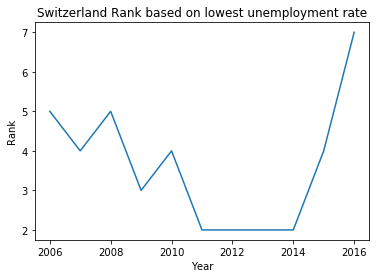

In [15]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(x, y)
plt.ylabel('Rank')
plt.xlabel('Year')
plt.title('Switzerland Rank based on lowest unemployment rate')
plt.show

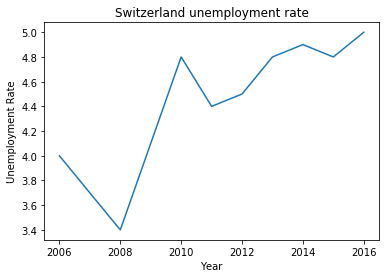

In [16]:
plt.plot(x_rate, y_rate)
plt.ylabel('Unemployment Rate')
plt.xlabel('Year')
plt.title('Switzerland unemployment rate')
plt.show()

#### Observations:

Switzerland consistently has one of the lowest unemployment rates in Europe (EU/EFTA) over the past decade. It ranks in the top 25 percentile for lowest unemployment rate and at one point from 2011 to 2014, it ranked at number 2 for the lowest unemployment rate in Europe. Interestingly, the unemployment rate in Switzerland, although low, has gradually been increasing over the last decade, ranging from 3.4 to 5%.

### Todo
1. Select the data we want:
 * Which countries? Only EU or all the 51 countries?
 * Which number? We don't have too many monthly numbers. Some countries have a lot of missing data, e.g. Switzerland.
2. Combine the numbers with topojson.
3. Plot the map. Adjust the visualization.
4. How to indicate NaNs (if any)?
5. "Compare Switzerland's unemployment rate to that of the rest of Europe."
6. Find a way to present our homework.

## Task 2

In [17]:
# load data
df = pd.read_excel('Data/2_1 Taux de chômage.xlsx', header=[5, 6])
df.drop('Mesures', axis=1, level=1, inplace=True)
df

ValueError: Length of new names must be 1, got 2

### Todo
Almost everything. Just started.

# Task 3

In [ ]:
# For mapping Italian canton names to the names used in the topojson file
canton_dict = json.load(open('Data/canton_names_it.json', encoding='utf-8'))
# For mapping Italian column names to English
column_dict = json.load(open('Data/column_names_it.json', encoding='utf-8'))


In [ ]:
# Load the data
ch_foreign_empl_data = pd.read_csv('Data/2_1 Tasso di disoccupazione.csv',
                   skiprows=[0, 1, 3],
                   encoding='utf-16-le',
                   #index_col=[0, 1],
                   usecols=[0, 1, 3, 4, 5, 6, 7, 8, 9, 10, 11],
                   skipfooter=1,
                   engine='python'
    )

# Translate nationality from Italian
ch_foreign_empl_data['Nazionalità'].replace('stranieri', 'Foreign', inplace=True)
ch_foreign_empl_data['Nazionalità'].replace('svizzeri', 'Swiss', inplace=True)

# Make Canton names match the topojson file
ch_foreign_empl_data['Cantone'].replace(canton_dict, inplace=True)

# Translate column names to English
ch_foreign_empl_data.rename(columns=column_dict, inplace=True)
#ch_foreign_empl_data.set_index(['Canton', 'Nationality'], inplace=True)

ch_foreign_empl_data['Average'] = ch_foreign_empl_data.mean(axis=1, numeric_only=True)

ch_foreign_empl_data.head()

In [ ]:
ch_coord = [46.849, 8.394]
canton_topo_path = 'topojson/ch-cantons.topojson.json'
canton_topo_data=json.load(open(canton_topo_path))
ch_map = folium.Map(location=ch_coord, zoom_start=8)
ch_map.choropleth(canton_topo_data,
                  topojson='objects.cantons',
                  data=ch_foreign_empl_data[ch_foreign_empl_data.Nationality == 'Foreign'],
                  key_on='feature.properties.name',
                  fill_color = 'BuPu',
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  columns=('Canton', 'Average'),
                  name='Foreign',
                  highlight=True,
                  legend_name='Unemployment rate of foreign workers')
ch_map.choropleth(canton_topo_data,
                  topojson='objects.cantons',
                  data=ch_foreign_empl_data[ch_foreign_empl_data.Nationality == 'Swiss'],
                  key_on='feature.properties.name',
                  fill_color = 'YlOrRd',
                  fill_opacity = 0.7,
                  line_opacity = 0.2,
                  columns=('Canton', 'Average'),
                  name='Swiss',
                  legend_name='Unemployment rate of Swiss workers')
folium.LayerControl().add_to(ch_map)
ch_map